In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [43]:
# Task 1

df = pd.read_csv('heart.csv')

# Balance or not
print(df['target'].value_counts())

majority = df[df['target'] == 1]
minority = df[df['target'] == 0]

minority_resample = resample(minority, replace=True, n_samples=len(majority))

df = pd.concat([majority,minority_resample])

print(df['target'].value_counts())

# Missing values or not
df.isnull().sum() # No missing values
# Categorical feature or not
df.select_dtypes(include=['object']).columns # No categorical features
# Duplicate records or not
df.duplicated().sum()

df.drop_duplicates(inplace=True)

scalar = StandardScaler()
X = df.drop('target',axis = 1)
Y = df['target']
X_scaled = scalar.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(X_scaled,Y,test_size=0.2,random_state=0)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.3,random_state=0)

Rf = RandomForestClassifier()
Ab = AdaBoostClassifier()
total = [Rf,Ab]
for i in total:
    model = i.fit(X_train,Y_train)
    Y_pred1 = model.predict(X_train)
    Y_pred2 = model.predict(X_test)
    print(f"\nAccuracy scores of {i}: \n")
    acc1 = accuracy_score(Y_train,Y_pred1)
    acc2 = accuracy_score(Y_test,Y_pred2)

    print(f"Accuracy 1: {acc1*100} %")
    print(f"Accuracy 2: {acc2*100} %")
    

target
1    526
0    499
Name: count, dtype: int64
target
1    526
0    526
Name: count, dtype: int64

Accuracy scores of RandomForestClassifier(): 

Accuracy 1: 100.0 %
Accuracy 2: 85.0 %

Accuracy scores of AdaBoostClassifier(): 

Accuracy 1: 95.83333333333334 %
Accuracy 2: 85.0 %


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Hard Voting Classifier score: 74.15%
Soft Voting Classifier score: 73.66%

Best voting method: Hard

Finding Best Weights...
Best Weights: DT=1, KNN=1, RF=1
Best Accuracy: 73.66%


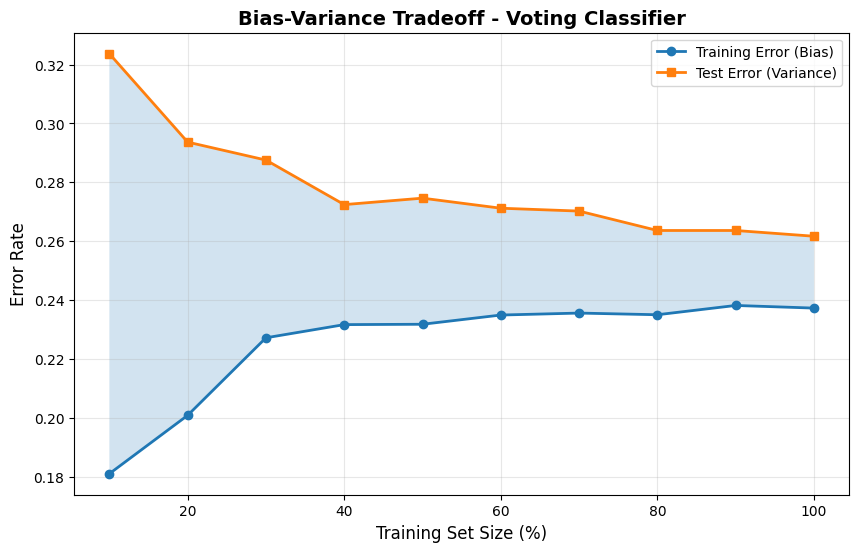

In [ ]:
# Task 2

df = pd.read_csv('heart.csv')

# Extract features
features = ['restecg', 'oldpeak']
X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

DT = DecisionTreeClassifier(random_state=42)
KNN = KNeighborsClassifier()
RF = RandomForestClassifier(random_state=42)
# XGB = XGBClassifier(random_state=42, eval_metric='logloss')

# Hard Voting
VC1 = VotingClassifier(
    estimators=[('DT', DT), ('KNN', KNN), ('RF', RF)],
    voting='hard'
)

# Soft Voting
VC2 = VotingClassifier(
    estimators=[('DT', DT), ('KNN', KNN), ('RF', RF)],
    voting='soft'
)

# Fit models
VC1.fit(X_train_scaled, y_train)
VC2.fit(X_train_scaled, y_train)

# Test on unseen data
hard_score = VC1.score(X_test_scaled, y_test) * 100
soft_score = VC2.score(X_test_scaled, y_test) * 100

print(f"Hard Voting Classifier score: {hard_score:.2f}%")
print(f"Soft Voting Classifier score: {soft_score:.2f}%")
print(f"\nBest voting method: {'Soft' if soft_score > hard_score else 'Hard'}\n")

# Find best weights
print("Finding Best Weights...")

from itertools import product

best_accuracy = 0
best_weights = None

for weights in product([1, 2, 3], repeat=3):
    VC_weighted = VotingClassifier(
        estimators=[('DT', DT), ('KNN', KNN), ('RF', RF)],
        voting='soft',
        weights=weights
    )
    VC_weighted.fit(X_train_scaled, y_train)
    acc = VC_weighted.score(X_test_scaled, y_test)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_weights = weights

print(f"Best Weights: DT={best_weights[0]}, KNN={best_weights[1]}, "
      f"RF={best_weights[2]}")
print(f"Best Accuracy: {best_accuracy*100:.2f}%")

# Bias-Variance Tradeoff Plot (Done by ChatGPT.... Kuch samajh nahi aaya kiya hua hai is main)
train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
test_errors = []

for size in train_sizes:
    train_err = []
    test_err = []
    
    for _ in range(20):
        indices = np.random.choice(len(X_train_scaled), 
                                   int(len(X_train_scaled) * size), 
                                   replace=False)
        X_boot = X_train_scaled[indices]
        y_boot = y_train.iloc[indices]
        
        VC_boot = VotingClassifier(
            estimators=[('DT', DT), ('KNN', KNN), ('RF', RF)],
            voting='soft',
            weights=best_weights
        )
        VC_boot.fit(X_boot, y_boot)
        
        train_err.append(1 - VC_boot.score(X_boot, y_boot))
        test_err.append(1 - VC_boot.score(X_test_scaled, y_test))
    
    train_errors.append(np.mean(train_err))
    test_errors.append(np.mean(test_err))

# Plot Bias-Variance Tradeoff
plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, train_errors, 'o-', label='Training Error (Bias)', linewidth=2)
plt.plot(train_sizes * 100, test_errors, 's-', label='Test Error (Variance)', linewidth=2)
plt.fill_between(train_sizes * 100, train_errors, test_errors, alpha=0.2)
plt.xlabel('Training Set Size (%)', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('Bias-Variance Tradeoff - Voting Classifier', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [54]:
# Task 3

df = pd.read_csv('heart.csv')

features = ['restecg', 'chol']

X = df[features]
Y = df['target']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0,stratify=Y)

RF = RandomForestClassifier(random_state=42)
AB = AdaBoostClassifier(random_state=42)

RF.fit(X_train,Y_train)
AB.fit(X_train,Y_train)

TrainaccRF = accuracy_score(Y_train,RF.predict(X_train))*100
TestaccRF = accuracy_score(Y_test,RF.predict(X_test))*100

TrainaccAB = accuracy_score(Y_train,AB.predict(X_train))*100
TestaccAB = accuracy_score(Y_test,AB.predict(X_test))*100

print(f"\nRandom Forest:")
print(f"  Training Accuracy: {TrainaccRF:.2f}%")
print(f"  Testing Accuracy:  {TestaccRF:.2f}%")

print(f"\nRandom Forest:")
print(f"  Training Accuracy: {TrainaccAB:.2f}%")
print(f"  Testing Accuracy:  {TestaccAB:.2f}%")

VC = VotingClassifier(estimators=[('RF',RF),('AB',AB)],voting='soft')

VC.fit(X_train,Y_train)
VCTrain = accuracy_score(Y_train,VC.predict(X_train)) * 100
VCTest = accuracy_score(Y_test,VC.predict(X_test)) * 100
print(f"\nVoting Classifier Score: {VCTrain:.2f} %")
print(f"Voting Classifier Score: {VCTest:.2f} %")


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Random Forest:
  Training Accuracy: 88.41%
  Testing Accuracy:  83.41%

Random Forest:
  Training Accuracy: 69.15%
  Testing Accuracy:  64.39%

Voting Classifier Score: 88.41 %
Voting Classifier Score: 83.41 %


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


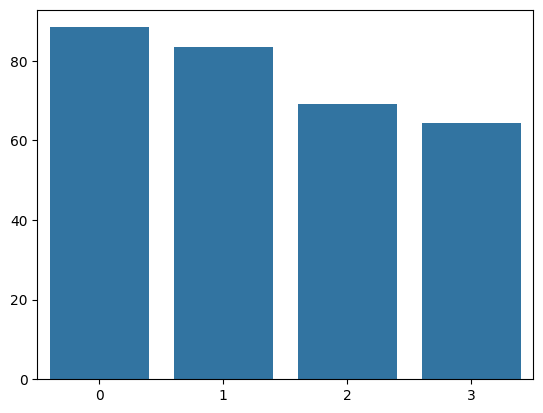

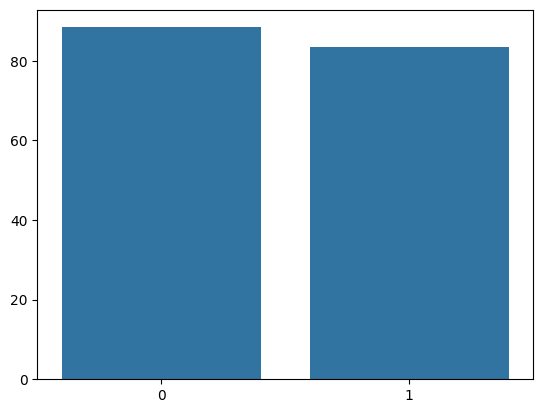

In [55]:
sns.barplot([TrainaccRF,TestaccRF,TrainaccAB,TestaccAB],legend=['Train RF','Test RF','Train AB','Test AB'],fill=True)
plt.show()
sns.barplot([VCTrain,VCTest],legend=['Train VC','Test VC'],fill=True)
plt.show()